Map:   0%|          | 0/2112 [00:00<?, ? examples/s]

Trainer is attempting to log a value of "[0.6875     0.625      0.83333333 0.78698225 0.52631579 0.87662338
 0.92376682 0.78723404 0.85904255 0.78571429 0.71428571 0.63333333]" of type <class 'numpy.ndarray'> for key "eval/precision_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.83018868 0.46875    0.71428571 0.74719101 0.43478261 0.76704545
 0.92128801 0.84090909 0.94169096 0.6875     0.78125    0.59375   ]" of type <class 'numpy.ndarray'> for key "eval/recall_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.75213675 0.53571429 0.76923077 0.76657061 0.47619048 0.81818182
 0.92252575 0.81318681 0.8984701  0.73333333 0.74626866 0.61290323]" of type <class 'numpy.ndarray'> for key "eval/f1_per_class" as a scalar. This invocation of Tensorboard's writer.add_sca


Per-Class Evaluation Metrics for RoBERTa:
     Category  Precision   Recall  F1-Score  Accuracy
National News   0.923767 0.921288  0.922526  0.921288
       Sports   0.859043 0.941691  0.898470  0.941691
Entertainment   0.876623 0.767045  0.818182  0.767045
      Opinion   0.787234 0.840909  0.813187  0.840909
     Business   0.833333 0.714286  0.769231  0.714286
      Economy   0.786982 0.747191  0.766571  0.747191
         Bank   0.687500 0.830189  0.752137  0.830189
      Tourism   0.714286 0.781250  0.746269  0.781250
   Technology   0.785714 0.687500  0.733333  0.687500
        World   0.633333 0.593750  0.612903  0.593750
         Blog   0.625000 0.468750  0.535714  0.468750
   Employment   0.526316 0.434783  0.476190  0.434783


<Figure size 1400x600 with 0 Axes>

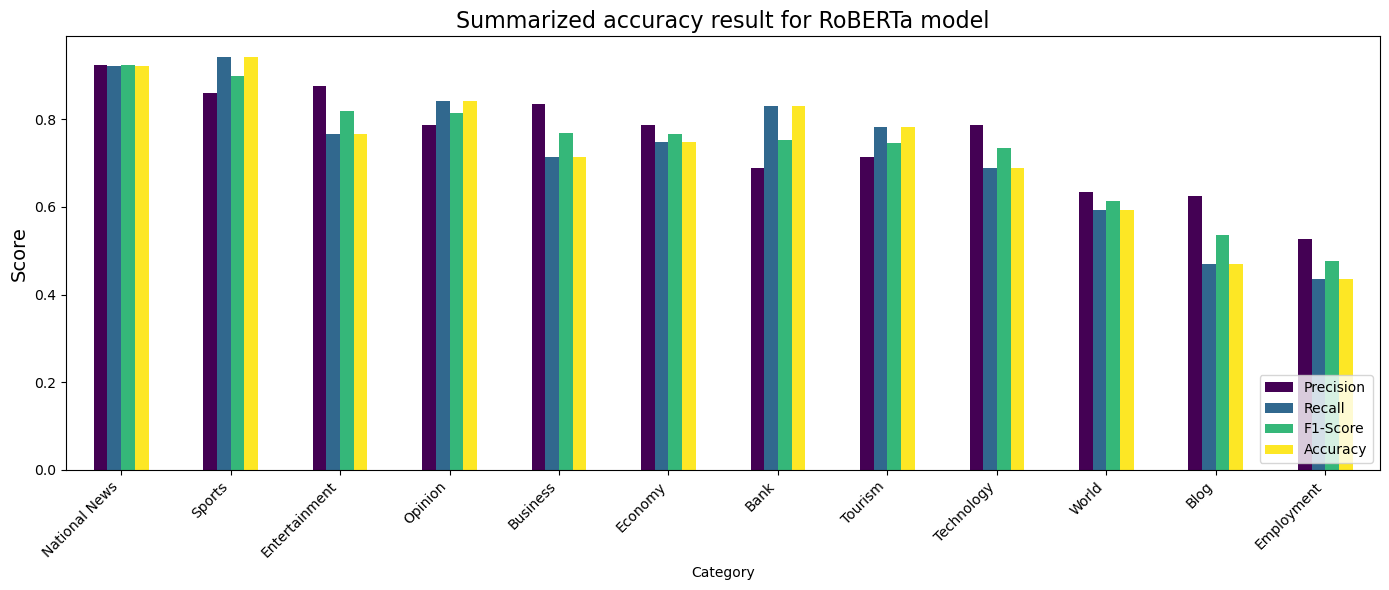


Per-Class Accuracy:
Bank: 0.8302
Blog: 0.4688
Business: 0.7143
Economy: 0.7472
Employment: 0.4348
Entertainment: 0.7670
National News: 0.9213
Opinion: 0.8409
Sports: 0.9417
Technology: 0.6875
Tourism: 0.7812
World: 0.5938

Overall Accuracy: 0.8684

Weighted Metrics:
Weighted Precision: 0.8678
Weighted Recall: 0.8684
Weighted F1-Score: 0.8669


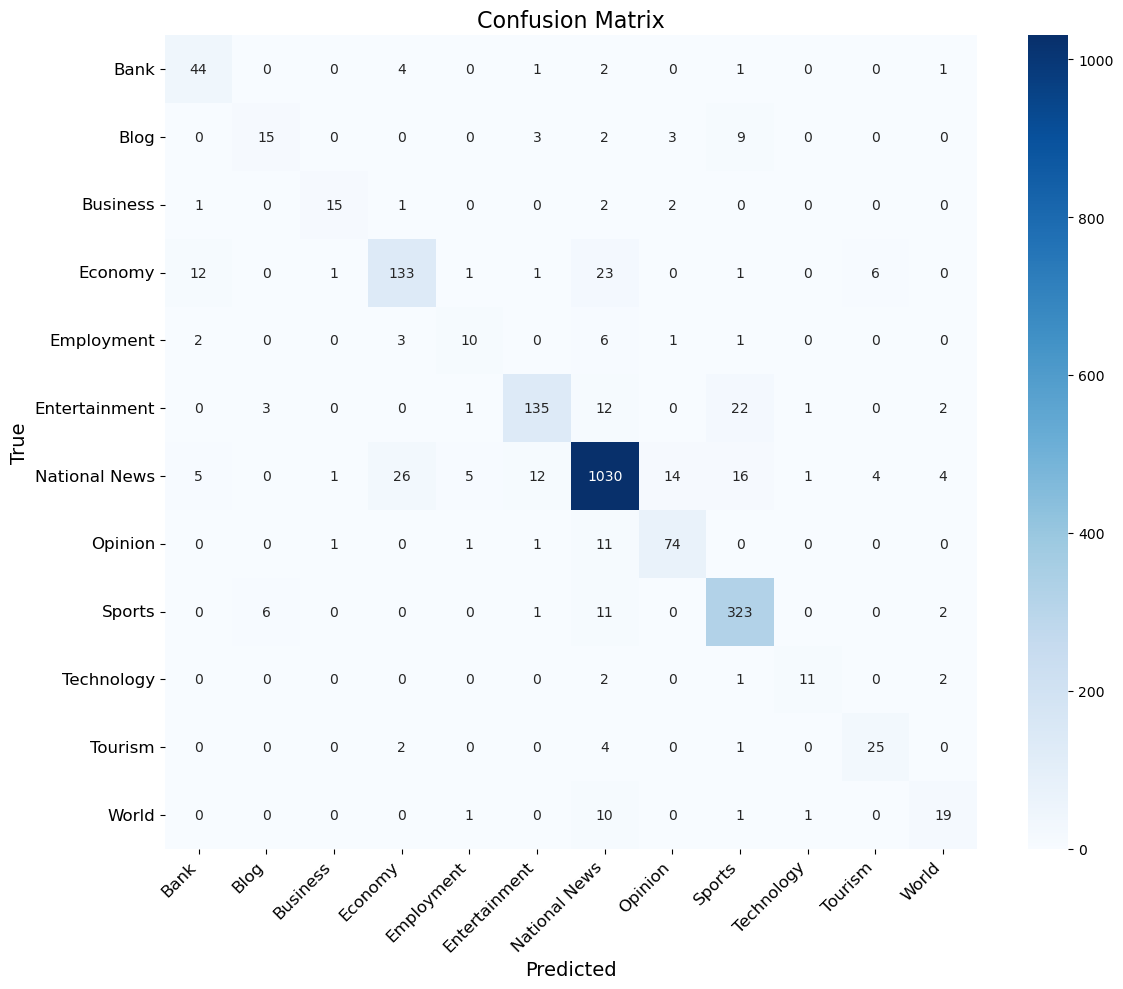

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import json
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# # News Classification Using BERT
# fine_model_name = "./nepali_news_mbert_fine_tuned_model/checkpoint-2958"
# model_tokenizer = "bert-base-multilingual-uncased"
# model_name = "BERT"

# News Classification Using RoBERTa
fine_model_name = "./nepali_news_roberta_fine_tuned_model3e5/checkpoint-3944"
model_tokenizer = "xlm-roberta-base"
model_name = "RoBERTa"

# # News Classification Using DistilBERT
# fine_model_name = "./nepali_news_distillbert_fine_tuned_model"
# model_tokenizer = "distilbert-base-multilingual-cased"
# model_name = "DistilBERT"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(fine_model_name, num_labels=12)
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

# Load the test data from CSV
test_df = pd.read_csv('3_split_data/test.csv')
test_df = test_df.dropna(subset=['content'])
test_df = test_df[test_df['content'].apply(lambda x: isinstance(x, str))]
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    cleaned_content = [str(content) if isinstance(content, str) else "" for content in examples['content']]
    return tokenizer(cleaned_content, padding="max_length", truncation=True)

test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load and invert label mapping
label_mapping_path = '1_combined_dataset/label_mapping.json'
with open(label_mapping_path, 'r') as json_file:
    label_mapping = json.load(json_file)

class_names = [None] * 12
for class_name, idx in label_mapping.items():
    class_names[idx] = class_name

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'confusion_matrix': conf_matrix
    }

training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=10,
    eval_strategy="no",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

results = trainer.evaluate(eval_dataset=test_dataset)

# Compute per-class accuracy
conf_matrix = results['eval_confusion_matrix']
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Create a DataFrame without weighted metrics
eval_df = pd.DataFrame({
    'Category': class_names,
    'Precision': results['eval_precision_per_class'],
    'Recall': results['eval_recall_per_class'],
    'F1-Score': results['eval_f1_per_class'],
    'Accuracy': class_accuracy
})

# Sort by F1-score for better readability
eval_df = eval_df.sort_values(by='F1-Score', ascending=False)

# Print evaluation metrics
print(f"\nPer-Class Evaluation Metrics for {model_name}:")
print(eval_df.to_string(index=False))

# Visualize evaluation metrics without weighted summary
plt.figure(figsize=(14, 6))
eval_df.set_index('Category')[['Precision', 'Recall', 'F1-Score', 'Accuracy']].plot(kind='bar', figsize=(14, 6), colormap='viridis')
plt.title(f"Summarized accuracy result for {model_name} model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"images/evaluation_metrics_{model_name}.png", dpi=600, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for class_idx, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[class_idx]:.4f}")
print(f"\nOverall Accuracy: {results['eval_accuracy']:.4f}")

# Print weighted metrics at last
print("\nWeighted Metrics:")
print(f"Weighted Precision: {results['eval_weighted_precision']:.4f}")
print(f"Weighted Recall: {results['eval_weighted_recall']:.4f}")
print(f"Weighted F1-Score: {results['eval_weighted_f1']:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(f"images/confusion_matrix_{model_name}.png", dpi=600, bbox_inches='tight')
plt.show()
